In [1]:
from call_sam3_worker import call_sam_worker

In [2]:
SAM_ENV_PYTHON = "/home/crest/e/NasBackup/hwang_Pro/jupyter/18_sam3_word_seg/.venv/bin/python3" # Linux/macOS
# SAM_ENV_PYTHON = ".\\env_sam\\Scripts\\python.exe" # Windows

# 注意：worker 脚本现在是 sam3_wrap.py
WORKER_SCRIPT = "/home/crest/e/NasBackup/hwang_Pro/jupyter/18_sam3_word_seg/sam3_wrap.py"

In [3]:
from pathlib import Path

import numpy as np

In [4]:
NAS_ROOT = Path("/home/crest/w/hwang_Pro/data/202509_tanashi_broccoli")

In [5]:
TEST_IMAGE_PATHS = [
    str(NAS_ROOT / "11_root_position" / "dom_part" / "2.tif"), 
    str(NAS_ROOT / "11_root_position" / "dom_part" / "12.tif")
]

TEST_PROMPT = "plant"

TEMP_DIR = str(NAS_ROOT / "11_root_position" / "dom_sam3" )

In [6]:
from PIL import Image

In [7]:
image = Image.open("/home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_part/12.tif")

In [8]:
image.mode

'RGBA'

In [9]:
try:
    # 调用 worker
    sam_result = call_sam_worker(
        sam_env_python_path=SAM_ENV_PYTHON,
        worker_script_path=WORKER_SCRIPT,
        image_list=TEST_IMAGE_PATHS,
        prompt=TEST_PROMPT,
        bpe_path="/home/crest/e/NasBackup/hwang_Pro/jupyter/18_sam3_word_seg/weights/sam3/bpe_simple_vocab_16e6.txt.gz",
        ckpt_path="/home/crest/e/NasBackup/hwang_Pro/jupyter/18_sam3_word_seg/weights/sam3/sam3.pt",
        temp_dir=TEMP_DIR
    )

    print(sam_result)
    
    # 在主程序中处理结果
    # masks_array = np.array(sam_result['masks'], dtype=np.uint8)
    
    # print("\n--- Result in Main App ---")
    # print(f"Successfully received masks from worker.")
    # print(f"Masks shape: {masks_array.shape}")
    # print(f"Masks dtype: {masks_array.dtype}")
    
    # 在这里继续使用 masks_array 和其他需要 numpy>=2.0 的库进行后续处理
    # ...
    
except (RuntimeError, FileNotFoundError) as e:
    print(f"\nAn error occurred: {e}")
    print("Please ensure the virtual environment paths and script paths are correct.")


Executing command: /home/crest/e/NasBackup/hwang_Pro/jupyter/18_sam3_word_seg/.venv/bin/python3 /home/crest/e/NasBackup/hwang_Pro/jupyter/18_sam3_word_seg/sam3_wrap.py --image_list /home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_part/2.tif /home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_part/12.tif --prompt plant --bpe_path /home/crest/e/NasBackup/hwang_Pro/jupyter/18_sam3_word_seg/weights/sam3/bpe_simple_vocab_16e6.txt.gz --ckpt_path /home/crest/e/NasBackup/hwang_Pro/jupyter/18_sam3_word_seg/weights/sam3/sam3.pt --temp_dir /home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_sam3
{'status': 'success', 'message': 'save to /home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_sam3'}


## 解析npz结果

In [10]:
test_npz = NAS_ROOT / "11_root_position" / "dom_sam3" / "12.npz"

In [ ]:
def read_sam3_npz(filepath):
    """从 .npz 文件中重建 list of dicts 结构。"""
    data = np.load(filepath)

    item = {
        'masks': data['masks'],
        'boxes': data['boxes'],
        'scores': data['scores']
    }
        
    return item

In [ ]:
item = read_sam3_npz(test_npz)

In [15]:
item

{'masks': array([[[[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False]]],
 
 
        [[[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False]]],
 
 
        [[[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ..., False, False

In [18]:
import torch
import supervision as sv

In [39]:
def visualize_sam_result(image, masks, boxes, scores, show=False, save_path=None):
        """
        可视化 SAM/SAM2 的分割结果。
        
        Args:
            image (np.ndarray): 原始图像 (H, W, 3).
            masks (Tensor or np.ndarray): 分割掩码.
            boxes (Tensor or np.ndarray): 边界框.
            scores (Tensor or np.ndarray): 置信度分数.
            show (bool): 是否直接显示图像.
            save_path (str, optional): 如果提供路径，则保存图像.
            
        Returns:
            np.ndarray: 绘制好结果的图像.
        """
        
        # --- 1. 数据预处理 (Tensor -> Numpy) ---
        # 定义一个辅助函数来转换数据
        def to_numpy(x):
            if isinstance(x, torch.Tensor):
                return x.detach().cpu().numpy()
            return np.array(x)
        masks_np = to_numpy(masks)
        boxes_np = to_numpy(boxes)
        scores_np = to_numpy(scores)
        # --- 2. 形状修正 ---
        # SAM 有时输出 (N, 1, H, W)，supervision 需要 (N, H, W)
        if masks_np.ndim == 4:
            masks_np = np.squeeze(masks_np, axis=1)
        
        # 确保 mask 是布尔类型
        masks_np = masks_np.astype(bool)
        # --- 3. 构建 Detections 对象 ---
        detections = sv.Detections(
            xyxy=boxes_np,
            mask=masks_np,
            confidence=scores_np
        )
        # --- 4. 初始化标注器 (关键修改：指定颜色策略) ---
        # 使用 INDEX 策略，根据检测框的索引分配颜色，避免因缺少 class_id 报错
        
        # Mask 标注器
        mask_annotator = sv.MaskAnnotator(
            color_lookup=sv.ColorLookup.INDEX,
            opacity=0.7
        )
        # Box 标注器 (这里修复了你之前的 ValueError)
        box_annotator = sv.BoxAnnotator(
            thickness=3,
            color_lookup=sv.ColorLookup.INDEX 
        )
        # Label 标注器 (显示分数)
        label_annotator = sv.LabelAnnotator(
            text_position=sv.Position.TOP_LEFT,
            text_scale=3,
            color_lookup=sv.ColorLookup.INDEX
        )
        # --- 5. 绘图 ---
        annotated_image = image.copy()
        
        # 绘制 Mask
        annotated_image = mask_annotator.annotate(
            scene=annotated_image, 
            detections=detections
        )
        
        # 绘制 Box
        annotated_image = box_annotator.annotate(
            scene=annotated_image, 
            detections=detections
        )
        
        # 绘制 Label (分数)
        labels = [f"{score:.2f}" for score in detections.confidence]
        annotated_image = label_annotator.annotate(
            scene=annotated_image, 
            detections=detections, 
            labels=labels
        )
        # --- 6. 显示或保存 ---
        if show:
            sv.plot_image(annotated_image)
            
        if save_path:
            import skimage as ski
            ski.io.imsave(save_path, np.array(annotated_image))
        return annotated_image

In [19]:
image = Image.open(NAS_ROOT / "11_root_position" / "dom_part" / "12.tif")

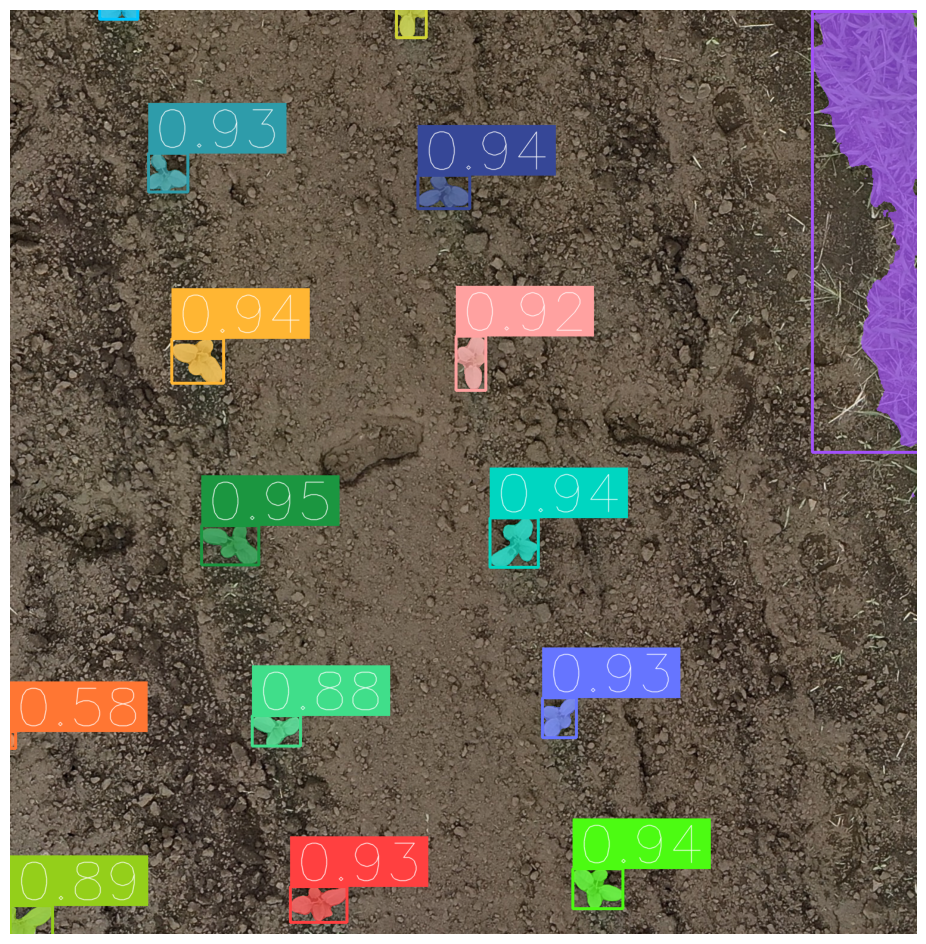

In [21]:
vis = visualize_sam_result(image, item["masks"], item['boxes'], scores=item['scores'], show=True)

## For循环所有的sam？

In [25]:
target_dir = NAS_ROOT / "11_root_position" / "dom_part"

# 使用列表推导式生成文件路径列表
# 1. target_dir.iterdir() 会遍历目录下的所有项目（文件和文件夹）
# 2. if path.is_file() 会筛选出其中是文件的项目
# 3. str(path) 将 Path 对象转换为字符串，与你示例中的格式完全一致
TEST_IMAGE_PATHS = [str(path) for path in target_dir.iterdir() if path.is_file()]

print(TEST_IMAGE_PATHS)

['/home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_part/0.tif', '/home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_part/1.tif', '/home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_part/2.tif', '/home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_part/3.tif', '/home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_part/4.tif', '/home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_part/5.tif', '/home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_part/6.tif', '/home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_part/7.tif', '/home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_part/8.tif', '/home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_part/9.tif', '/home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_part/10.tif', '/home/crest/w/hwang_Pro/data/

In [26]:
try:
    # 调用 worker
    sam_result = call_sam_worker(
        sam_env_python_path=SAM_ENV_PYTHON,
        worker_script_path=WORKER_SCRIPT,
        image_list=TEST_IMAGE_PATHS,
        prompt=TEST_PROMPT,
        bpe_path="/home/crest/e/NasBackup/hwang_Pro/jupyter/18_sam3_word_seg/weights/sam3/bpe_simple_vocab_16e6.txt.gz",
        ckpt_path="/home/crest/e/NasBackup/hwang_Pro/jupyter/18_sam3_word_seg/weights/sam3/sam3.pt",
        temp_dir=TEMP_DIR
    )

    print(sam_result)
    
except (RuntimeError, FileNotFoundError) as e:
    print(f"\nAn error occurred: {e}")
    print("Please ensure the virtual environment paths and script paths are correct.")


Executing command: /home/crest/e/NasBackup/hwang_Pro/jupyter/18_sam3_word_seg/.venv/bin/python3 /home/crest/e/NasBackup/hwang_Pro/jupyter/18_sam3_word_seg/sam3_wrap.py --image_list /home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_part/0.tif /home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_part/1.tif /home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_part/2.tif /home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_part/3.tif /home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_part/4.tif /home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_part/5.tif /home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_part/6.tif /home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_part/7.tif /home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_part/8.tif /home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/1

## 循环所有可视化

In [27]:
ALL_IMAGE_PATHS = [path for path in target_dir.iterdir() if path.is_file()]

ALL_IMAGE_PATHS

[PosixPath('/home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_part/0.tif'),
 PosixPath('/home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_part/1.tif'),
 PosixPath('/home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_part/2.tif'),
 PosixPath('/home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_part/3.tif'),
 PosixPath('/home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_part/4.tif'),
 PosixPath('/home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_part/5.tif'),
 PosixPath('/home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_part/6.tif'),
 PosixPath('/home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_part/7.tif'),
 PosixPath('/home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_part/8.tif'),
 PosixPath('/home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_part/9.tif'),


In [41]:
for path_img in ALL_IMAGE_PATHS:

    image = Image.open(path_img)

    img_npz = path_img.parent.parent / "dom_sam3" / f"{path_img.stem}.npz"

    item = reconstruct_output_list(img_npz)

    vis_path = path_img.parent.parent / "dom_sam3_vis" / f"raw_{path_img.stem}.png"

    print(vis_path)

    vis = visualize_sam_result(image, 
                               item["masks"], item['boxes'], scores=item['scores'],
                               save_path=vis_path)

    print(test_npz)

/home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_sam3_vis/raw_0.png
/home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_sam3/0.npz
/home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_sam3_vis/raw_1.png
/home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_sam3/0.npz
/home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_sam3_vis/raw_2.png
/home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_sam3/0.npz
/home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_sam3_vis/raw_3.png
/home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_sam3/0.npz
/home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_sam3_vis/raw_4.png
/home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_sam3/0.npz
/home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_sam3_vis/raw_5.png
/home/crest/w/hwa

UnidentifiedImageError: cannot identify image file '/home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/dom_part/0.tif.aux.xml'